# Hierarchical characterisation plots




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [47]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import scipy.cluster.hierarchy as sh
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress
import collections
import cPickle as pickle

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import hierarchicalrandomnetwork

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2, 'legend.frameon': False})

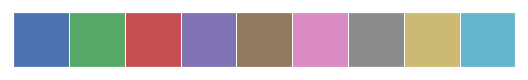

In [79]:
current_palette = sns.color_palette("deep")
del current_palette[1]
sns.palplot(current_palette)

sns.set_palette(current_palette)


In [48]:
savefig = True

In [4]:
dataio = DataIO(label='hierarchical_char', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/hierarchical_network')

=== FileIO ready: /home/loic/thesis/code/Bayesian-visual-working-memory/Experiments/thesis_plots/hierarchical_network/hierarchical_char-376c91eb-e54d-4e52-969c-5f08d932a751 ===


# Exploration of parameters controlling weights and threshold

This is to show the effect of lambda, p and theta.

Lambda is actually not used... it cancels out :P

Most of the early plots are in 1try: [here](../hierarchical_network_characterisation/notebook_hierarchical_weights_1try_270818.ipynb)

But the better plots for the thesis should be in [4try here](../hierarchical_network_characterisation/notebook_hierarchical_weights_4try_300818.ipynb)

# Weights distribution plots

In [170]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='none',
    N=200,
    num_samples=50,
    label='thesis_hierarchical_weights',
    output_directory='./Figures/thesis/hierarchical_weights/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M=100,
    M_layer_one=40,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    normalise_weights=1,
    normalise_gain=None,
    threshold=1.0,
    sparsity=1.0,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network


In [191]:
dataio = DataIO(label='weights_sparsity%.2f' % arguments_dict['sparsity'], 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/hierarchical_network')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/hierarchical_network/weights_sparsity0.05-95b7f6dc-bddd-48c8-858c-3f494364b3ee ===


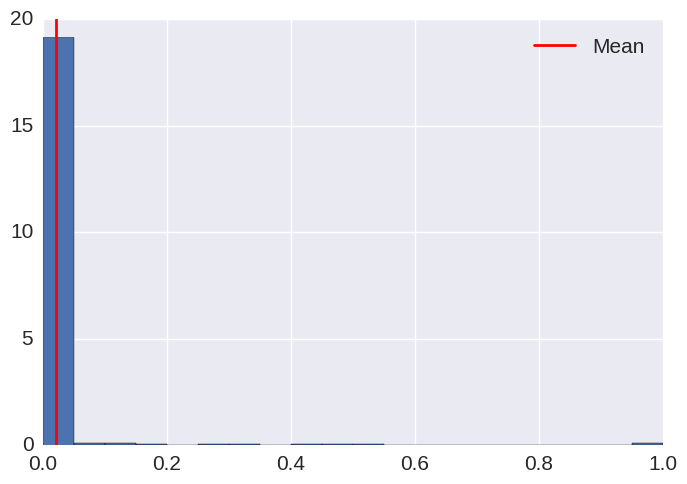

In [192]:
weights = network.A_sampling

f, ax = plt.subplots()
ax.hist(weights.flatten(), bins=20, normed=True)
ax.axvline(np.mean(weights), color='r')
ax.legend(['Mean'])

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('weights_histogram_{label}.pdf'), 
                      bbox_inches='tight')

Average number of input neurons:
1.43


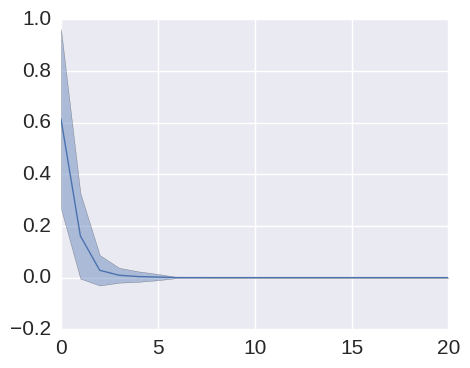

In [193]:
# Average weights coming in, sorted.
sorted_weights = np.sort(weights, axis=-1)[:, -21:]
weights_mean = np.mean(sorted_weights, axis=0)[::-1]
weights_std = np.std(sorted_weights, axis=0)[::-1]

print "Average number of input neurons:"
print np.mean(np.sum(weights > (np.mean(weights) + 1*np.std(weights)), axis=1))

_, ax = plt.subplots(figsize=(5, 4))
utils.plot_mean_std_area(np.arange(weights_mean.size), weights_mean, weights_std, ax_handle=ax)
if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('weights_topvalues_{label}.pdf'), 
                      bbox_inches='tight')


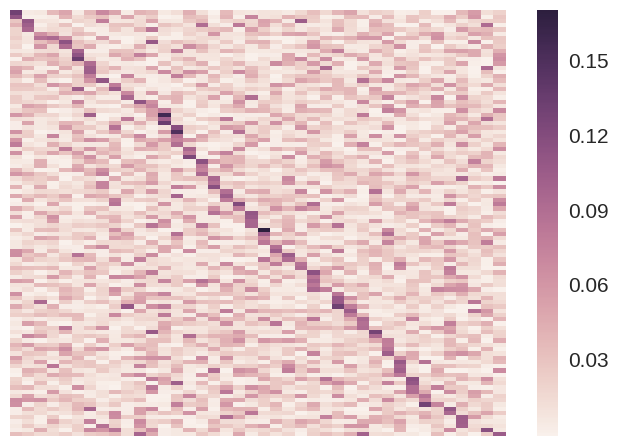

In [174]:
ax = sns.heatmap(weights[np.argsort(np.argmax(weights, axis=-1))], xticklabels=False, yticklabels=False)
if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('weights_sorted_{label}.pdf'), 
                      bbox_inches='tight')

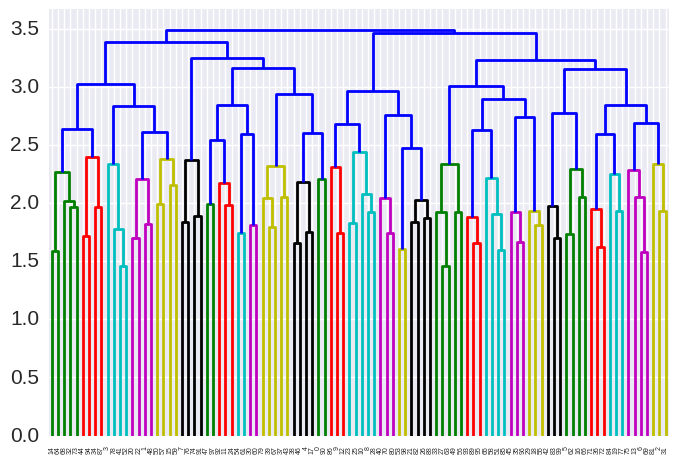

In [175]:
# Hierarchial clustering of weights
weights_nonzero = weights[np.any(weights > 0, axis=1)]
corr_weights = np.corrcoef(weights_nonzero)
corr_weights_low = np.corrcoef(weights_nonzero.T)
corr_weights[np.isnan(corr_weights)] = 0

# dists = sh.distance.pdist(corr_weights)
cluster_hier = sh.linkage(corr_weights, method='complete')
cluster_index = sh.fcluster(cluster_hier, 0., 'distance')
sh.dendrogram(cluster_hier);

-0.0012738784278 0.159638791932 0.0533672777947


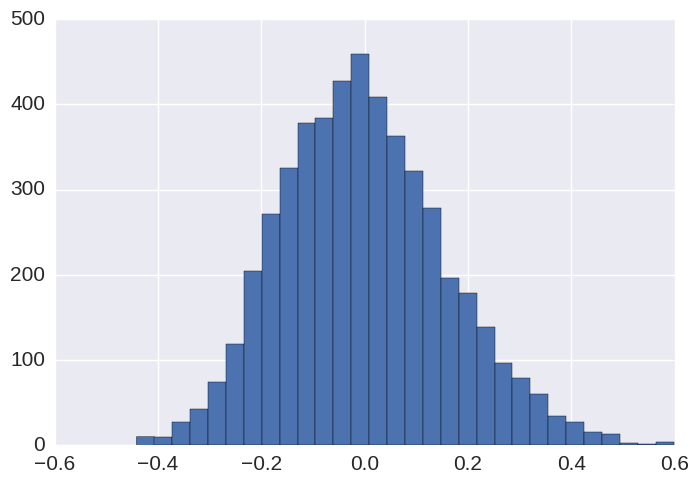

In [176]:
i_x, i_y = np.triu_indices_from(corr_weights, k=1)
corr_weights_up = corr_weights[i_x, i_y]

plt.hist(corr_weights[i_x, i_y], bins=30)
print np.mean(corr_weights_up), np.std(corr_weights_up), spst.kurtosis(corr_weights_up)

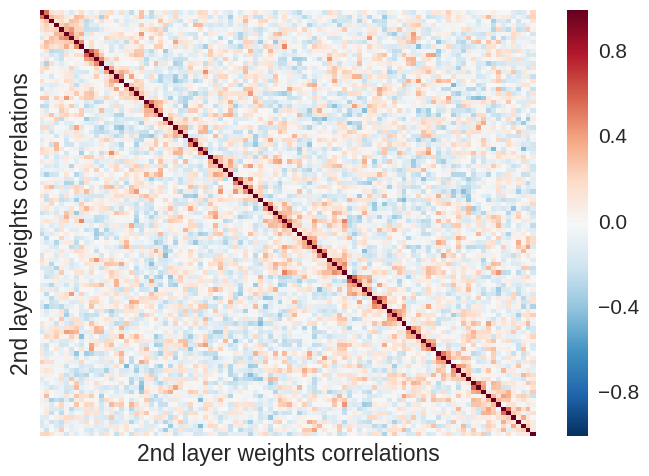

In [177]:
ordering = np.argsort(cluster_index)

ax = sns.heatmap(corr_weights[ordering, :][:, ordering], xticklabels=False, yticklabels=False)
ax.set_xlabel('2nd layer weights correlations')
ax.set_ylabel('2nd layer weights correlations')

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('weights_correlations_{label}.pdf'), 
                  bbox_inches='tight')

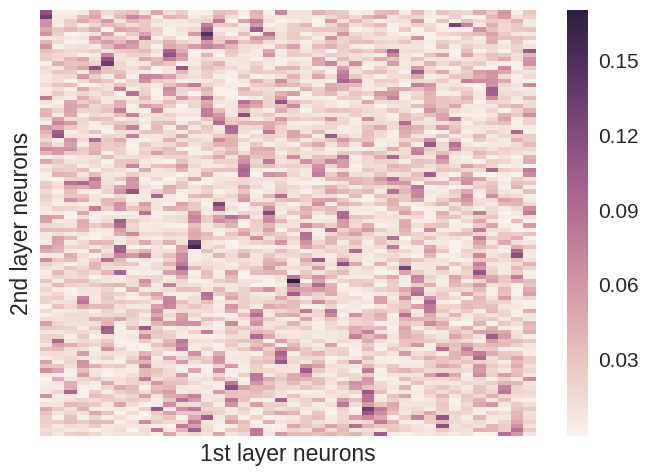

In [178]:
ax = sns.heatmap(weights[ordering, :], xticklabels=False, yticklabels=False)
ax.set_xlabel('1st layer neurons')
ax.set_ylabel('2nd layer neurons')

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('weights_ordered_corr_{label}.pdf'), 
                  bbox_inches='tight')

In [179]:
# g = sns.clustermap(weights, method='single', xticklabels=False, yticklabels=False)
# g.ax_heatmap.set_xlabel('lower layer neurons')
# g.ax_heatmap.set_ylabel('higher layer neurons')

# if savefig:
#     g.savefig(dataio.create_formatted_filename('weights_clustermap_weights_{label}_{unique_id}.pdf'), 
#           bbox_inches='tight')

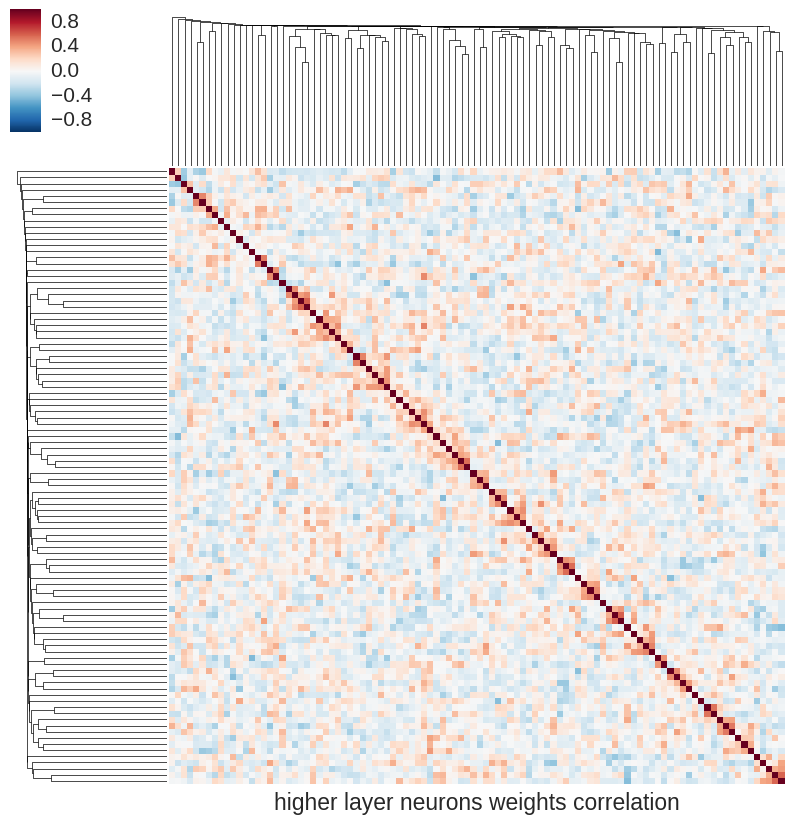

In [180]:
g = sns.clustermap(corr_weights, method='single', xticklabels=False, yticklabels=False)
g.ax_heatmap.set_xlabel('higher layer neurons weights correlation')

if savefig:
    g.savefig(dataio.create_formatted_filename('weights_clustermap_correlation_{label}.pdf'), 
              bbox_inches='tight')

(0.062907746767067368, 0.0091231892856852969)


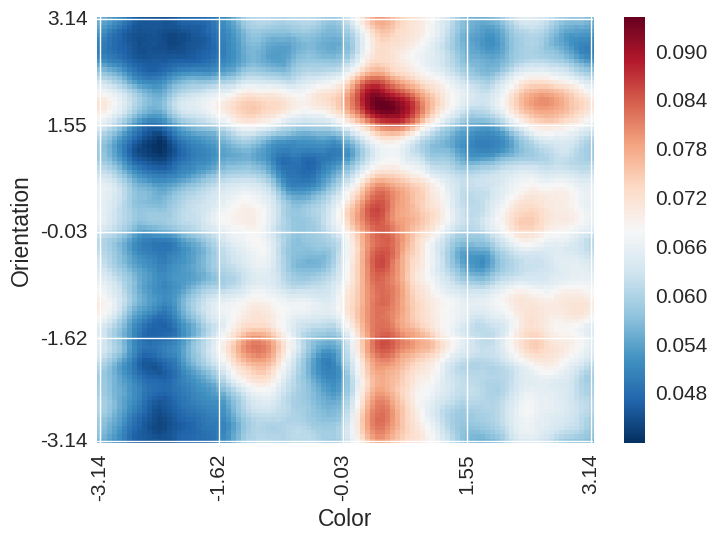

In [181]:
ax, _ = network.plot_mean_activity()

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('mean_activity_{label}.pdf'), 
                  bbox_inches='tight')

In [182]:
# sparsity_space = np.linspace(0.05, 1.0, 10)
sparsity_space = np.array([0.05, 0.15, 0.3, 0.5, 1.0])
M_layer_one = 50
M_layer_two = 50
num_repetitions = 5

corr_all_values = collections.defaultdict(list)
corr_stats = {}

for i, sparsity in enumerate(sparsity_space):
    for repet_i in xrange(num_repetitions):
        weights = np.random.exponential(1, (M_layer_two, M_layer_one)) * ( 
            np.random.rand(M_layer_two, M_layer_one) <= sparsity)
        weights /= np.sum(weights, axis=1)[:, np.newaxis]
        weights[np.isnan(weights)] = 0

        corr_weights = np.corrcoef(weights)
        # weights_nonzero = weights[np.any(weights > 0, axis=1)]
        # corr_weights = np.corrcoef(weights_nonzero)
        corr_weights[np.isnan(corr_weights)] = 0

        i_x, i_y = np.triu_indices_from(corr_weights, k=1)
        corr_weights_up = corr_weights[i_x, i_y]
        
        corr_all_values['correlations'].extend(corr_weights_up)
        corr_all_values['sparsity'].extend([sparsity,]*len(corr_weights_up))
        corr_all_values['repetitions'].extend(range(len(corr_weights_up)))
        
corr_df = pd.DataFrame(corr_all_values)

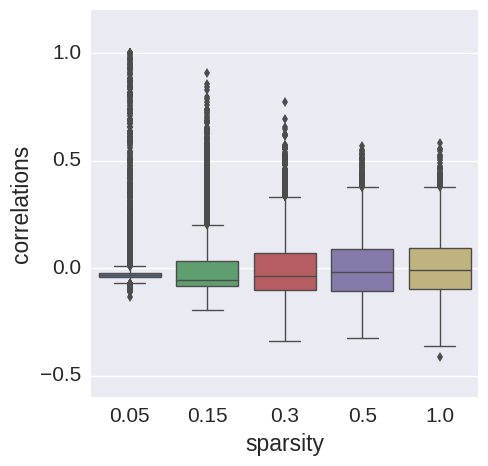

In [183]:
f, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=corr_df, x='sparsity', y='correlations',  
               linewidth=1, ax=ax)
# ax.set_ylim((-0.5, 1))
# ax.set_xlim((-0.7, 4.3))

# Assess sensitivity of higher layer neurons

- Need to check "how much binding information" they provide.
- Or maybe "how many top layer neurons respond per (orientation/colour) tuple


In [184]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='none',
    N=200,
    num_samples=50,
    label='thesis_hierarchical_weights',
    output_directory='./Figures/thesis/hierarchical_weights/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M=100,
    M_layer_one=40,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    normalise_weights=1,
    normalise_gain=None,
    threshold=1.0,
    sparsity=0.05,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network

weights = network.A_sampling

In [185]:
dataio = DataIO(label='hierarchical_char', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/hierarchical_network')

=== FileIO ready: /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/thesis_plots/hierarchical_network/hierarchical_char-e2d38f56-bee0-45b8-97ea-2d2395e0d7af ===


In [186]:
precision = 100
coverage_1D = utils.init_feature_space(precision)

possible_stimuli = np.array(utils.cross(network.R * [coverage_1D.tolist()]))
activity = np.empty((possible_stimuli.shape[0], network.M))

for stimulus_i, stimulus in enumerate(possible_stimuli):
    activity[stimulus_i] = network.get_network_response(stimulus)
activity.shape = network.R * (precision, ) + (network.M, )

In [187]:
activity_mean = np.mean(activity, axis=-1)
activity_std = np.std(activity, axis=-1)
activity_on = (activity > (activity_mean + 1*activity_std)[:, :, np.newaxis])
active_neurons = np.sum(activity_on, axis=-1)

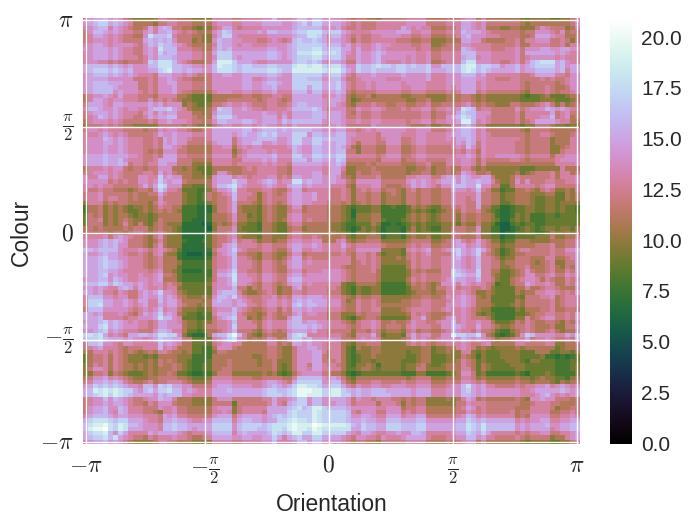

In [188]:
ax, _ = utils.pcolor_2d_data(active_neurons, cmap='cubehelix', colorbar=True, vmin=0)
selected_ticks = np.array(
    np.linspace(0, coverage_1D.size - 1, 5), dtype=int)
ax.set_xticks(selected_ticks)
ax.set_xticklabels(
    (r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'),
    fontsize=17,
    rotation=0)
ax.set_yticks(selected_ticks)
ax.set_yticklabels(
    (r'$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'),
    fontsize=17,
    rotation=0)
ax.set_xlabel('Orientation')
ax.set_ylabel('Colour')

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename(
            'number_active_neurons_sparsity%.2f_{label}.pdf' % (network.sparsity_weights)), 
                      bbox_inches='tight')


In [189]:
sparsity_space = np.linspace(0.01, 1.0, 100)
M_layer_one = 40
M_layer_two = 100
num_repetitions = 100

sensitivity_values = collections.defaultdict(list)

for i, sparsity in enumerate(sparsity_space):
    for repet_i in xrange(num_repetitions):
        weights = np.random.exponential(1, (M_layer_two, M_layer_one)) * ( 
            np.random.rand(M_layer_two, M_layer_one) <= sparsity)
        weights /= np.sum(weights, axis=1)[:, np.newaxis]
        weights[np.isnan(weights)] = 0
        
        # Check which top level neurons integrate over two features
        weights_mean = np.mean(weights, axis=0)
        weights_std = np.std(weights, axis=0)
        weights_active = (weights > weights_mean + 1.*weights_std)

        sensitive_feature_1 = np.sum(weights_active[:, :M_layer_one/2], axis=-1)
        sensitive_feature_2 = np.sum(weights_active[:, -M_layer_one/2:], axis=-1)
        
        sensitivity_values['single'].append(np.mean((sensitive_feature_1 > 0) | ((sensitive_feature_2 > 0))))
        sensitivity_values['binding'].append(np.mean((sensitive_feature_1 > 0) & ((sensitive_feature_2 > 0))))
        sensitivity_values['sparsity'].append(sparsity)
        sensitivity_values['repetition'].append(repet_i)
        
sensitivity_df = pd.DataFrame(sensitivity_values)


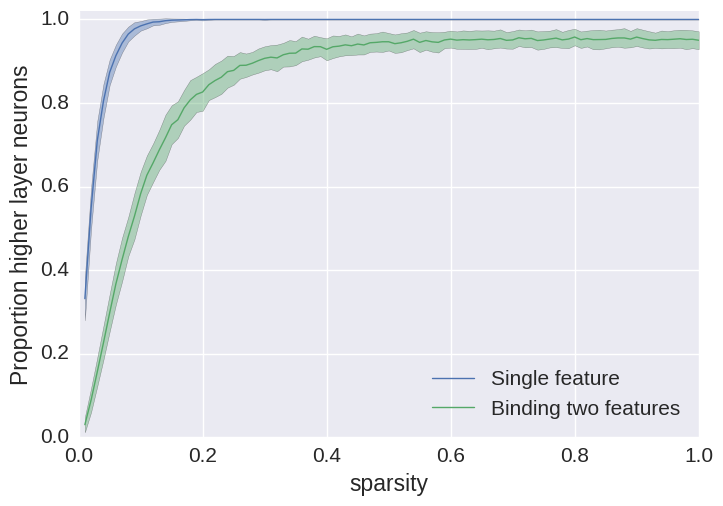

In [169]:
df_avgstd = sensitivity_df.groupby(('sparsity'), as_index=False).agg(('mean', 'std')).reset_index()
df_avgstd.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd.columns.values]
df_avgstd.columns = [s.split('_mean')[0] for s in df_avgstd.columns]
ax = utils.plot_mean_std_area(df_avgstd['sparsity'], df_avgstd['single'], df_avgstd['single_std'], 
                              xlabel='sparsity', ylabel='Proportion higher layer neurons')
ax = utils.plot_mean_std_area(df_avgstd['sparsity'], df_avgstd['binding'], df_avgstd['binding_std'], 
                              xlabel='sparsity', ylabel='Proportion higher layer neurons', ax_handle=ax)
ax.set_ylim((0, 1.02))
ax.legend(["Single feature", "Binding two features"], loc='best')

if savefig:
    ax.figure.savefig(dataio.create_formatted_filename('proportion_binding_neurons_sparsity_{label}.pdf'),
                      bbox_inches='tight')


# Average precision as a function of angle

In [141]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='none',
    N=500,
    num_samples=50,
    label='thesis_hierarchical_weights',
    output_directory='./Figures/thesis/hierarchical_weights/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M_layer_one=49,
    M=100,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    normalise_weights=1,
    normalise_gain=None,
    threshold=1.0,
    sparsity=1.0,
    sigmax=0.1,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network


In [237]:
# 1D precision as a function of the angle
df_precision = sampler.estimate_precision_per_angle(fit_mixture_model=False, num_repetitions=100)

[100%] 10s                                                                    


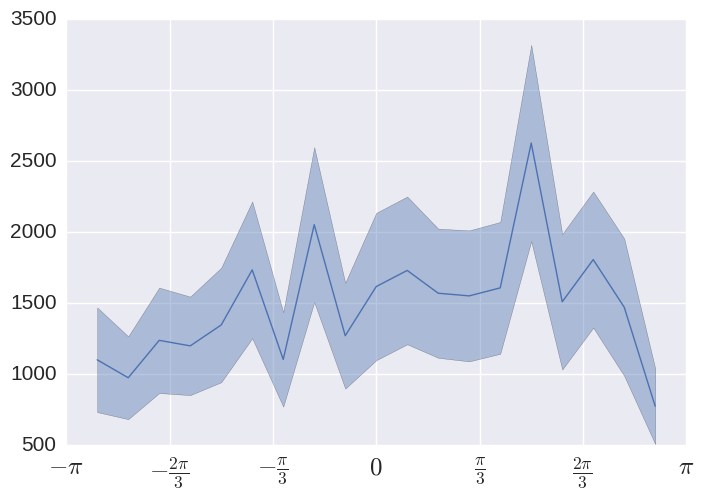

In [239]:
ax = sampler.plot_precision_per_angle(df_precision, x='target', value='precisions')
ax.figure.savefig(dataio.create_formatted_filename('precision_per_angle_{label}.pdf'), 
                  bbox_inches='tight')

In [144]:
# 2D version
df_precision_2d = sampler.estimate_precision_twoangles(num_repetitions=3)

-> init theta, feature 1 cued, time 1
Computing normalisations ...
... done
[100%] 2m51s                                                                  


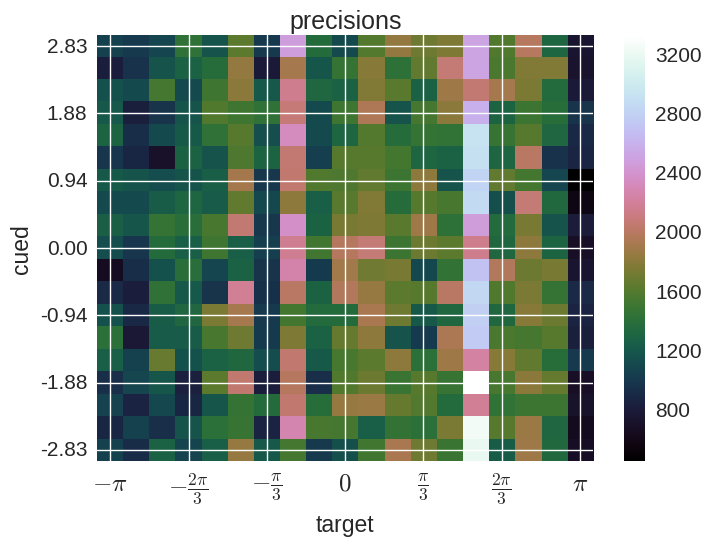

In [240]:
ax = sampler.plot_precision_twoangles(df_precision_2d, value='precisions')
ax.figure.savefig(dataio.create_formatted_filename('precision_twoangles_{label}.pdf'), 
                  bbox_inches='tight')

# 2D plot of M and ratio hierarchical

In [152]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if "std_" + interpolate_column in df:
        w = 1./df["std_" + interpolate_column]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [153]:
%cd /nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels/

with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fit_mixturemodels_hierarchical_Mratio_grid_270617.py

/nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels


In [154]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [155]:
pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=utils.process_precision)),
    ('result_em_fits', dict(name='emfit', process=utils.process_em_fits)),
]

df_all_fits = utils.construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

M_space = np.sort(df_all_fits['M'].unique())
ratio_hier_space = np.sort(df_all_fits['ratio_hierarchical'].unique())


/nfs/nhome/live/lmatthey/Documents/work/Visual_working_memory/code/git-bayesian-visual-working-memory/utils_directional_stats.py:83: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-2. * np.log(spsp.i1e(kappa) / spsp.i0e(kappa)))


In [213]:
targets_fidelity = [500, 1000, 2000]
clip_distance = 200

for target_fidelity in targets_fidelity:
    df_all_fits.loc[:, 'emfit_fidelity_distance_{}'.format(target_fidelity)] = np.clip(
        df_all_fits.emfit_fidelity/target_fidelity, -clip_distance, clip_distance)

In [214]:
df_all_fits.describe()

,precision,std_precision,precision_stddev,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,std_emfit_kappa,std_emfit_fidelity,std_emfit_stddev,M,ratio_hierarchical,emfit_fidelity_distance_500,emfit_fidelity_distance_1000,emfit_fidelity_distance_2000
count,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.0,7.487000e+03,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000
mean,3991.736356,694.635522,0.159008,4023.599779,0.978108,0.0,2.189188e-02,374.139820,-732.384688,4023.096779,0.063166,692.560805,692.561226,0.010732,206.283558,0.481181,8.046194,4.023097,2.011548
std,6430.506159,1188.558411,0.337546,6427.886042,0.081547,0.0,8.154744e-02,234.703870,469.407741,6427.887887,0.095922,1279.552250,1279.551968,0.044882,111.197136,0.281932,12.855776,6.427888,3.213944
min,0.152124,0.003705,0.007181,0.317672,0.012694,0.0,3.219017e-12,-367.432741,-1465.443641,0.269925,0.005074,0.079706,0.079963,0.000004,10.000000,0.000100,0.000540,0.000270,0.000135
25%,174.330541,31.075074,0.020677,215.768604,0.997903,0.0,5.468535e-11,240.236260,-1097.722500,215.267632,0.014374,32.115339,32.115604,0.001099,110.000000,0.237450,0.430535,0.215268,0.107634
50%,1091.233759,197.426089,0.044743,1129.929015,1.000000,0.0,5.665825e-10,413.611516,-811.328080,1129.428831,0.029756,175.152505,175.152567,0.002513,205.000000,0.474800,2.258858,1.129429,0.564714
75%,4826.630930,808.944271,0.123725,4840.689843,1.000000,0.0,2.096762e-03,556.808726,-464.577567,4840.189800,0.068157,788.653812,788.653814,0.006522,302.500000,0.727300,9.680380,4.840190,2.420095
max,38834.377506,11031.307570,3.669424,38834.877512,1.000000,0.0,9.873059e-01,740.669297,750.760434,38834.377506,1.924769,40027.138423,40027.148950,1.011548,395.000000,0.989900,77.668755,38.834378,19.417189


In [215]:
# Remove outliers
df_fits_filtered = utils.remove_outliers(df_all_fits, 5)

In [219]:
# Quantize parameters to smooth stuff up a bit

nQuantiles = 41
parameters = ['M', 'ratio_hierarchical']

df_fits_quants, param_qbins, param_qbins_middle = utils.df_add_quantize_parameters(
    df_fits_filtered, parameters, nQuantiles)
df_fits_q_avg = df_fits_quants.groupby(('M_qi', 'ratio_hierarchical_qi')).mean().reset_index()

In [221]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')

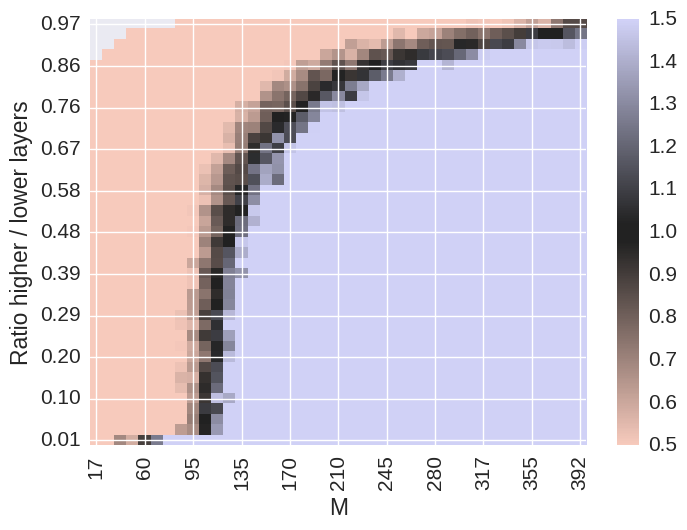

In [233]:
data_q_M_ratio = df_fits_q_avg.pivot_table(index='M_qi', 
                                           columns='ratio_hierarchical_qi', 
                                           values='emfit_fidelity_distance_500'
                                          ).as_matrix()

ax, _ = utils.pcolor_2d_data(data_q_M_ratio, x=param_qbins_middle['M'], y=param_qbins_middle['ratio_hierarchical'], 
                             xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
                             ticks_interpolate=11, cmap=cmap_div, log_scale=False, vmin=0.5, vmax=1.5)
ax.figure.savefig(dataio.create_formatted_filename('Mratio_effect_distance500_{label}_{unique_id}.pdf'), 
                  bbox_inches='tight')

# Encoding noise effect

In [7]:
arguments_dict = dict(    
    action_to_do='launcher_do_simple_run',
    inference_method='sample',
    N=100,
    num_samples=50,
    M=100,
    M_layer_one=49,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    normalise_weights=1,
    threshold=1.0,
    sparsity=1.0,
    normalise_gain=None,
    sigmax=0.1,
    sigmay=0.000001,
    label='thesis_encodingnoiseeffect_hierarchical',
    output_directory=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation',
    T=1,
    num_repetitions=1,
    renormalize_sigma=None,
    autoset_parameters=None,
    sigma_output=0.0,
    sigma_baseline=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network

sampler.fit_mixture_model()

{'K': 0.0,
 'aic': -341.87078462368106,
 'bic': -331.4501038797287,
 'kappa': 565.5529952861709,
 'mixt_nontargets': 0.0,
 'mixt_nontargets_sum': 0.0,
 'mixt_random': 2.5738669059324935e-10,
 'mixt_target': 0.9999999997426134,
 'train_LL': 174.93539231184053}

In [40]:
def plot_mean_std_area(x, y, std, ax_handle=None, linewidth=2, fmt='-', 
                       markersize=1, color=None, xlabel=None, ylabel=None, 
                       label='', title=None, zorder=1):
    '''
        Plot a given x-y data, with a transparent area for its standard deviation

        If ax_handle is given, plots on this figure.
    '''

    if ax_handle is None:
        f = plt.figure(fignum)
        ax_handle = f.add_subplot(111)

    if color is not None:
        ax = ax_handle.plot(
          x, y, fmt, linewidth=linewidth, markersize=markersize, color=color, label=label, zorder=zorder)
    else:
        ax = ax_handle.plot(
          x, y, fmt, linewidth=linewidth, markersize=markersize, label=label, zorder=zorder)

    current_color = ax[-1].get_c()

    if std is not None and np.any(std > 1e-6):
        ax_handle.fill_between(
          x, y-std, y+std, facecolor=current_color, alpha=0.4, zorder=zorder)

    if xlabel is not None:
        ax_handle.set_xlabel(xlabel)

    if ylabel is not None:
        ax_handle.set_ylabel(ylabel)

    if title is not None:
        ax_handle.set_title(title)

    ax_handle.get_figure().canvas.draw()

    return ax_handle

In [41]:
dataio = DataIO(label='encodingnoise_hierarchical_1', 
                calling_function='', 
                output_folder=os.environ['WORKDIR_DROP'] + '/Experiments/thesis_plots/hierarchical_network')

=== FileIO ready: /home/loic/thesis/code/Bayesian-visual-working-memory/Experiments/thesis_plots/hierarchical_network/encodingnoise_hierarchical_1-dee17f37-7c8e-4f2c-b74a-37616c014a2f ===


In [129]:
sigmax2_space = 0.5*np.logspace(-4, 0, 30)
num_repetitions = 30

num_params = sigmax2_space.size

cached_filename = ('/home/loic/thesis/code/Bayesian-visual-working-memory/Experiments/thesis_plots/'
                   'hierarchical_network/'
                   'encodingnoise_hierarchical_1-dee17f37-7c8e-4f2c-b74a-37616c014a2f.npy')


if os.path.exists(cached_filename):
  data = np.load(cached_filename).take(0)
  
  mem_fidelities = data['mem_fidelities']
  precisions = data['precisions']
  fisherinfos = data['fisherinfos']
else:
  mem_fidelities = np.zeros((num_repetitions, num_params))
  precisions = np.zeros((num_repetitions, num_params))
  fisherinfos = np.zeros((num_repetitions, num_params))

  search_progress = progress.Progress(num_params*num_repetitions)

  for repet_i in xrange(num_repetitions):
    for sigmax_i, sigmax2 in enumerate(sigmax2_space):
      print "{:.0f}% - {} - {}/{} Sigmax: {:.2g}".format(
        search_progress.percentage(), search_progress.time_remaining_str(), 
        repet_i+1, num_repetitions, sigmax2)
      arguments_dict['sigmax'] = sigmax2**0.5
      with io.capture_output(display=False, stdout=True) as captured:
        experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
        sampler = experiment_launcher.all_vars['sampler']

        mem_fidelities[repet_i, sigmax_i] = sampler.fit_mixture_model()['kappa']
        precisions[repet_i, sigmax_i] = sampler.get_precision()
        fisherinfos[repet_i, sigmax_i] = sampler.estimate_fisher_info_from_posterior_avg_randomsubset(
          subset_size=10)

      search_progress.increment()
  dataio.save_variables(['mem_fidelities', 'precisions', 'fisherinfos'], locals())
  print "stored data in: ", dataio.filename + ".npy"


In [130]:
# stats
mem_fidelities_log = np.log10(mem_fidelities)
mem_fidelities_avg = np.mean(mem_fidelities_log, axis=0)
mem_fidelities_std = np.std(mem_fidelities_log, axis=0)

fisher_conv = np.log10(fisherinfos/2.)
fisher_conv_avg = np.mean(fisher_conv, axis=0)
fisher_conv_std = np.std(fisher_conv, axis=0)

precisions_log = np.log10(precisions)
precisions_avg = np.mean(precisions_log, axis=0)
precisions_std = np.std(precisions_log, axis=0)

sigma2inv = np.log10(sigmax2_space**-1.)


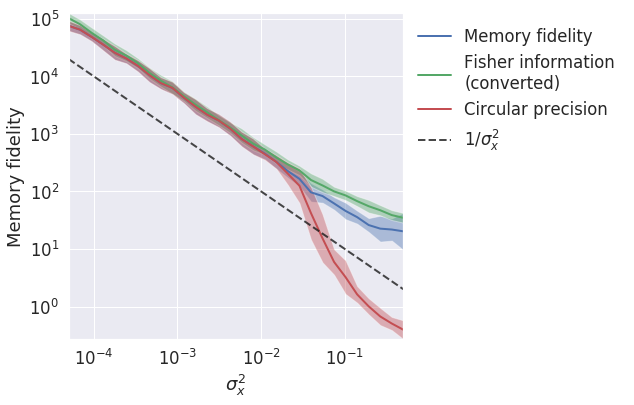

In [131]:
# plots
f, ax = plt.subplots(figsize=(6, 6))
ax.set_xscale('log')
# ax.set_yscale('log')
plot_mean_std_area(sigmax2_space, mem_fidelities_avg, mem_fidelities_std, ax_handle=ax)
plot_mean_std_area(sigmax2_space, fisher_conv_avg, fisher_conv_std, ax_handle=ax)
plot_mean_std_area(sigmax2_space, precisions_avg, precisions_std, ax_handle=ax)
ax.plot(sigmax2_space, sigma2inv, 'k--', alpha=0.8)

ax.set_xlabel('$\sigma_x^2$')
ax.set_ylabel('Memory fidelity')
ax.set_yticklabels(["$10^{}$".format(int(i)) for i in ax.get_yticks()])
legend = ax.legend(["Memory fidelity", "Fisher information \n(converted)", "Circular precision", 
                "$1/\sigma_x^2$"], 
               loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
ax.autoscale(enable=True, tight=True)

if savefig:
  f.savefig(dataio.create_formatted_filename("encoding_noise_effect_{label}_{unique_id}.pdf"), 
            bbox_inches='tight')

In [14]:
### Sparsity effect
# arguments_dict = dict(    
#     action_to_do='launcher_do_simple_run',
#     inference_method='sample',
#     N=200,
#     num_samples=50,
#     M=100,
#     M_layer_one=49,
#     code_type='hierarchical',
#     type_layer_one='feature',
#     output_both_layers=None,
#     normalise_weights=1,
#     threshold=1.0,
#     sparsity=0.3,
#     sigmax=0.1,
#     sigmay=0.000001,
#     label='thesis_sparsity_effect_hierarchical',
#     output_directory=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation',
#     T=1,
#     num_repetitions=1,
#     renormalize_sigma=None,
#     autoset_parameters=None,
#     sigma_output=0.0,
#     sigma_baseline=0.0,
#     selection_num_samples=1,
#     selection_method='last',
#     slice_width=0.07,
#     burn_samples=50,
#     enforce_min_distance=0.17,
#     specific_stimuli_random_centers=None,
#     stimuli_generation='random',
#     stimuli_generation_recall='random',
#     experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
# )
# with io.capture_output(display=False, stdout=True) as captured:
#     experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
#     sampler = experiment_launcher.all_vars['sampler']
#     network = sampler.random_network

# sampler.fit_mixture_model()

In [15]:
# dataio = DataIO(label='sparsity_hierarchical_1', 
#                 calling_function='', 
#                 output_folder=os.environ['WORKDIR_DROP'] + '/Figures/thesis/single_item_characterisation')

In [16]:
# # sparsity_space = np.logspace(-3, 0, 20)
# sparsity_space = np.linspace(0.0001, 1.0, 11)

# mem_fidelities = np.zeros_like(sparsity_space)
# precisions = np.zeros_like(sparsity_space)
# fisherinfos = np.zeros_like(sparsity_space)

# search_progress = progress.Progress(sparsity_space.size)

# for i, sparsity in enumerate(sparsity_space):
#     print "{:.0f}% - {} - Sparsity: {:.2g}".format(search_progress.percentage(), 
#                                              search_progress.time_remaining_str(), 
#                                              sparsity)
#     arguments_dict['sparsity'] = sparsity**0.5
#     with io.capture_output(display=False, stdout=True) as captured:
#         experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
#         sampler = experiment_launcher.all_vars['sampler']
        
#         mem_fidelities[i] = sampler.fit_mixture_model()['kappa']
#         precisions[i] = sampler.get_precision()
#         fisherinfos[i] = sampler.estimate_fisher_info_from_posterior_avg_randomsubset(subset_size=10)

#     search_progress.increment()

In [17]:
# f, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# axes[0].plot(sparsity_space, mem_fidelities, 'b')
# # axes[0].loglog(sparsity_space, sparsity_space**-1., 'b--')
# axes[0].set_xlabel('sparsity')
# axes[0].set_ylabel('Memory fidelity')
# axes[0].legend(["Memory fidelity"])
# axes[0].autoscale(enable=True, tight=True)

# axes[1].plot(sparsity_space, precisions, 'r')
# # axes[1].loglog(sparsity_space, sparsity_space**-1., 'r--')
# axes[1].set_xlabel('sparsity')
# axes[1].set_ylabel('Precision')
# axes[1].legend(["Precision"])
# axes[1].autoscale(enable=True, tight=True)

# axes[2].plot(sparsity_space, fisherinfos, 'g')
# # axes[2].loglog(sparsity_space, sparsity_space**-1., 'g--')
# axes[2].set_xlabel('sparsity')
# axes[2].set_ylabel('Fisher Information')
# axes[2].legend(["Fisher Information"])
# axes[2].autoscale(enable=True, tight=True)

# plt.tight_layout()

# # f.savefig(dataio.create_formatted_filename("sparsity_effect_{label}_{unique_id}.pdf"))